In [1]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from yacs.config import CfgNode

from src.features.perception import get_ray_directions_world_coords, propagate_labels
from src.features.raytracing import raytrace_3d
from src.visualisation.map_visualisation import draw_voxels


In [2]:
def sensor_cfg() -> CfgNode:
    sensor_cfg = CfgNode()
    sensor_cfg.WIDTH = 224 #px
    sensor_cfg.HEIGHT = 224 #px
    sensor_cfg.HFOV = 90 #deg
    sensor_cfg.SENSOR_HEIGHT = 0.88 #m
    return sensor_cfg

def map_cfg():
    cfg = CfgNode()
    cfg.RESOLUTION = 1.0  # cm per pixel
    cfg.EGOCENTRIC_MAP_SHAPE = (30,20,30)  # (x, y, z) in pixel
    cfg.NUM_SEMANTIC_CLASSES = 5
    cfg.SENSOR_CFG = sensor_cfg()
    return cfg

def generate_semantic_map(cfg, seed = None, p = 0.05, dtype = np.single):
    rng = np.random.default_rng(seed)
    grid_classes = rng.choice(np.arange(cfg.NUM_SEMANTIC_CLASSES), size = cfg.EGOCENTRIC_MAP_SHAPE)

    grid_classes_onehot = np.zeros((grid_classes.size, grid_classes.max() + 1), dtype = dtype)
    grid_classes_onehot[np.arange(grid_classes.size), grid_classes.flatten()] = 1
    grid_classes_onehot = grid_classes_onehot.reshape(cfg.EGOCENTRIC_MAP_SHAPE + (cfg.NUM_SEMANTIC_CLASSES,))
    
    grid = np.zeros(cfg.EGOCENTRIC_MAP_SHAPE, dtype = dtype)
    grid_flat = grid.flatten()
    grid_flat[:int(p*grid_flat.size)] = 1
    rng.shuffle(grid_flat)
    grid = grid_flat.reshape(cfg.EGOCENTRIC_MAP_SHAPE)
    grid_classes_onehot[np.invert(grid),:] = 0
    semantic_map_3d = np.concatenate([np.expand_dims(grid, -1), grid_classes_onehot], axis = -1).astype(dtype)
    return semantic_map_3d

def generate_empty_semantic_map(cfg):
    semantic_map_3d = np.zeros(cfg.EGOCENTRIC_MAP_SHAPE + (cfg.NUM_SEMANTIC_CLASSES + 1,))
    return semantic_map_3d

def add_hole_at_coords(semantic_map_3d, x, y, z, radius):
    semantic_map_3d[x-radius:x+radius, y-radius:y+radius, z-radius:z+radius, :] = 0
    return semantic_map_3d

In [3]:
sim_cfg = map_cfg()
semantic_map_3d = generate_semantic_map(sim_cfg, p = 0.9, dtype = bool)
semantic_map_3d = add_hole_at_coords(semantic_map_3d, 10, 10, 10, 5)


In [4]:
from src.utils.morphological_transformations import fill_holes, semantic_map_to_label_map
from scipy.ndimage.measurements import label, find_objects


In [5]:
label_map = semantic_map_to_label_map(semantic_map_3d, 0.5)
comparator = np.greater_equal
number_of_voxels_threshold = 5


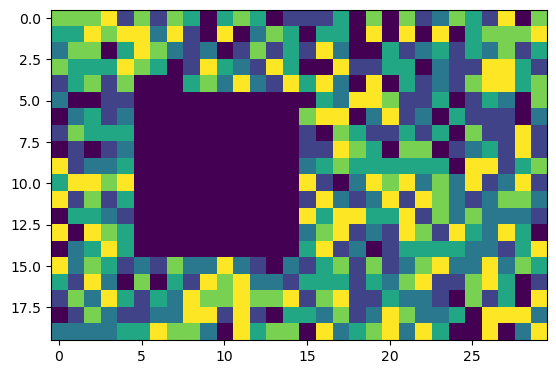

In [6]:
plt.imshow(label_map[10, :, :])

In [12]:
label_map = fill_holes(label_map, comparator = comparator, number_of_voxels_threshold = number_of_voxels_threshold)

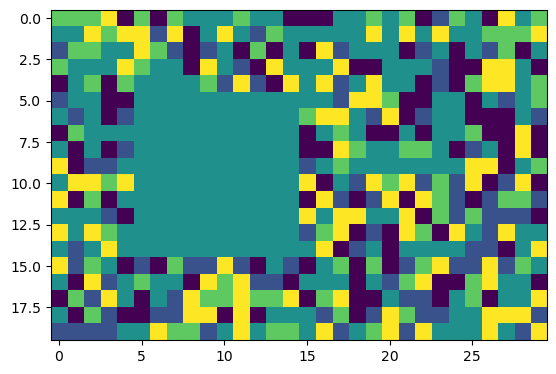

In [13]:
plt.imshow(label_map[10, :, :])